# **The Battle of the Neighborhoods - New York City vs Toronto**
## Final Project of the 'Applied Data Science Capstone' in Coursera

## 1- Introduction

In this final capstone project we will use the Foursquare API to explore neighborhoods in New York City (Manhattan) and Toronto. We will use the explore function to get the most common venue categories in each neighborhood and then use this feature to group the neighborhoods of the two cities into clusters and determine how similar or dissimilar they are.

This information will be useful to people moving from one city to the other, to help them in their decision making concerning which neighborhood to move into. Some people will prefer to move into a new neighborhood in a new city with similar caractheristics, in terms of venues, to the city previously inhabited. Some people might be interested to find something rather different. We hope this analysis can help them make a more informed decision.

## 2- Data

First let's import all the dependencies that we will need throughout this project:

In [2]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

print('Libraries imported.')

Libraries imported.


Now let's get the New York City dataset ready.Note that we will only consider Manhattan in the analysis.

In [3]:
import wget
url= 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'
wget.download(url)

'newyork_data (1).json'

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Now that we have the JSON file let's tranform the data into a pandas dataframe

In [5]:
NYneighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

NYneighborhoods = pd.DataFrame(columns=column_names)

for data in NYneighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NYneighborhoods = NYneighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Lets now select only neighborhoods from Manhattan and look at the dataframe.

In [6]:
NYneighborhoods = NYneighborhoods[NYneighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
NYneighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [59]:
print('The New York dataframe has {} boroughs and {} neighborhoods.'.format(
        len(Tneighborhoods['Borough'].unique()),
        Tneighborhoods.shape[0]
    )
)

The New York dataframe has 4 boroughs and 39 neighborhoods.


OK, the New York dataframe is ready. 

Now let's create the Toronto dataframe. In this cases we will use the BeautifulSoup package to scrape the table from Wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [8]:
url= requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url,'lxml')
table = soup.find('table',{'class':'wikitable sortable'})

Now we create the pandas dataframe

In [9]:
A=[]
B=[]
C=[]

for row in table.findAll('tr'):
    cells= row.findAll('td')
    if len(cells)==3:
        mlnk=cells[0].findAll('a')
        A.append(cells[0].find(text=True).strip())
        B.append(cells[1].find(text=True).strip())
        C.append(cells[2].find(text=True).strip())

Tneighborhoods= pd.DataFrame(A, columns=['PostalCode'])
Tneighborhoods['Borough']=B
Tneighborhoods['Neighbourhood']=C
Tneighborhoods.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Just a couple more steps to get the dataframe ready to go. First we will change the column name 'Neighbourhood' to 'Neighborhood' (to match the NY dataframe) and drop 'Boroughs' with 'Not assigned' names.

In [10]:
Tneighborhoods = Tneighborhoods.rename(columns={'Neighbourhood': 'Neighborhood'})

In [11]:
indexNames = Tneighborhoods[Tneighborhoods['Borough'] == 'Not assigned' ].index
Tneighborhoods.drop(indexNames , inplace=True)
Tneighborhoods.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


And get the coordinates of the neighborhoods from a csv file available at https://cocl.us/Geospatial_data and merge it with our Toronto dataframe

In [14]:
coordf = pd.read_csv('https://cocl.us/Geospatial_data')
coordf = coordf.rename(columns={'Postal Code': 'PostalCode'})
Tneighborhoods= pd.merge(Tneighborhoods, coordf, on='PostalCode')
Tneighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Let's just drop the PostalCode column which is not useful anymore and only consider the Boroughs with Toronto in the description for simplification

In [15]:
Tneighborhoods= Tneighborhoods.drop('PostalCode', 1)
Tneighborhoods = Tneighborhoods[Tneighborhoods['Borough'].str.contains('Toronto')].reset_index(drop=True)
Tneighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,Downtown Toronto,St. James Town,43.651494,-79.375418
4,East Toronto,The Beaches,43.676357,-79.293031


Alright, now we have both New York and Toronto dataframes ready. Let's merge them together into one single dataframe.

In [16]:
dataframes = [NYneighborhoods, Tneighborhoods]
df = pd.concat(dataframes)
df

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
...,...,...,...,...
34,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846
35,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675
36,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280
37,Downtown Toronto,Church and Wellesley,43.665860,-79.383160


And 'voilá', we have our dataframe with the Boroughs of New York and Toronto and their respective Neighborhoods, as well as their latitude and longitude. We are now ready for the analysis, to explore the venues in each city using the Foursquare API and compare both cities and their neighborhoods. 

## 3- Methodology

To begin, let's create a map with New York and Toronto neighborhoods superimposed on top. Since these cities are farther apart, it will be useful to zoom out and zoom in to have a closer look at each one at a time (note: we use Binghamton as the center of the map, just because it is more or less half-way between the two cities).


In [17]:
address = 'Binghamton, NY'
geolocator = Nominatim(user_agent="bing_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [18]:
map = folium.Map(location=[latitude, longitude], zoom_start=7)

for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map)  
    
map

Next, we are going to utilize the Foursquare API to explore the neighborhoods in both cities and segment them.

In [19]:
CLIENT_ID = '4ZSCABDBYVM0BWT4RKWFNT4UVE3K3EUU5JEANWJFTKFNS4FO'
CLIENT_SECRET = '5UBIP1IN2GIENFYCCUSVQTIAEQE2CGWDCQL3WKGDTIVENPGQ'
VERSION = '20201205'
LIMIT = 100

First, let's get the top 100 venues that are in all neighborhoods within a radius of 500 meters and create a dataframe.
Below is a function that will help us do that:


In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards
Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District


The size of the resulting dataframe is:

In [22]:
print(venues.shape)
venues.head()

(4826, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


We can also check how many unique catagories of venues exist in the dataset:

In [23]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 369 uniques categories.


Next, we will perform an 'one-hot encoding' to analyze each neighborhood concerning their venues.

In [24]:
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")
onehot = onehot.rename(columns={'Neighborhood': 'Neighbourhood'})
onehot['Neighborhood'] = venues['Neighborhood'] 
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]
onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
grouped = onehot.groupby('Neighborhood').mean().reset_index()
grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.015152,0.0,0.000000,0.000000
1,Berczy Park,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,"Business reply mail Processing Centre, South C...",0.000000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0,0.0,0.0,0.0625,0.0625,0.0625,0.125,0.125,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,Upper East Side,0.000000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,...,0.00,0.000000,0.0,0.0,0.0,0.000000,0.020619,0.0,0.020619,0.030928
75,Upper West Side,0.010204,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,...,0.00,0.010204,0.0,0.0,0.0,0.030612,0.010204,0.0,0.000000,0.010204
76,Washington Heights,0.011905,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,...,0.00,0.000000,0.0,0.0,0.0,0.011905,0.023810,0.0,0.011905,0.000000
77,West Village,0.010000,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.000,0.000,...,0.00,0.000000,0.0,0.0,0.0,0.040000,0.000000,0.0,0.000000,0.000000


Let's get the top 5 most common venues in each neighborhood into a pandas dataframe


In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = grouped['Neighborhood']

for ind in np.arange(grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Park,Hotel,Coffee Shop,Gym,Memorial Site
1,Berczy Park,Coffee Shop,Seafood Restaurant,Cheese Shop,Cocktail Bar,Beer Bar
2,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Nightclub,Climbing Gym
3,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Auto Workshop,Gym / Fitness Center,Restaurant,Skate Park
4,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Harbor / Marina,Sculpture Garden
...,...,...,...,...,...,...
74,Upper East Side,Exhibit,Italian Restaurant,Coffee Shop,Bakery,Gym / Fitness Center
75,Upper West Side,Italian Restaurant,Bar,Café,Coffee Shop,Indian Restaurant
76,Washington Heights,Café,Bakery,Grocery Store,Coffee Shop,Donut Shop
77,West Village,Italian Restaurant,New American Restaurant,American Restaurant,Park,Cocktail Bar


Let's now run a clustering algorithm, the k-means clustering. First we need to pick the k using the Within-Cluster-Sum-of-Squares (WCSS) method.

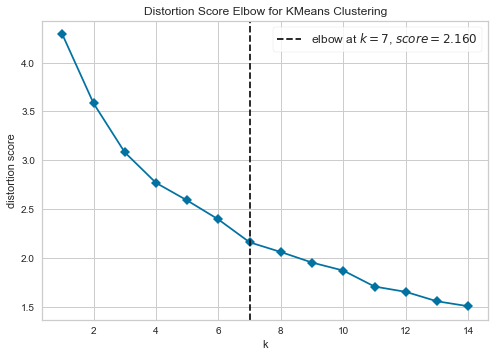

In [36]:
import random
random.seed(123)
grouped_clustering = grouped.drop('Neighborhood', 1)

# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,15), timings=False)
visualizer.fit(grouped_clustering)
visualizer.show()

Lets's use k= 7

In [37]:
kclusters = 7
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

Let's create a new dataframe that includes the clusters number as well as the top 5 venues for each neighborhood.

In [38]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
merged = df
merged = merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [39]:
merged.dropna(inplace= True)

In [40]:
merged['Cluster Labels']= merged['Cluster Labels'].astype(int)
merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,1,Coffee Shop,Sandwich Place,Discount Store,Gym,Yoga Studio
1,Manhattan,Chinatown,40.715618,-73.994279,5,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,5,Café,Bakery,Grocery Store,Coffee Shop,Donut Shop
3,Manhattan,Inwood,40.867684,-73.921210,5,Mexican Restaurant,Lounge,Restaurant,Café,Deli / Bodega
4,Manhattan,Hamilton Heights,40.823604,-73.949688,5,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Indian Restaurant


Let's look at the map again, now with the neighborhoods clustered

In [41]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(merged['Latitude'], merged['Longitude'], merged['Neighborhood'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

How do venues in each cluster relate to each other?  Let's have a look.

### Cluster 0

In [42]:
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[0] + [1] + list(range(4, merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
18,Central Toronto,Lawrence Park,0,Park,Swim School,Bus Line,Yoga Studio,Escape Room


### Cluster 1

In [43]:
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[0] + [1] + list(range(4, merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,1,Coffee Shop,Sandwich Place,Discount Store,Gym,Yoga Studio
17,Manhattan,Chelsea,1,Coffee Shop,American Restaurant,Bakery,Art Gallery,Café
26,Manhattan,Morningside Heights,1,Park,Bookstore,Coffee Shop,American Restaurant,Café
28,Manhattan,Battery Park City,1,Park,Hotel,Coffee Shop,Gym,Memorial Site
29,Manhattan,Financial District,1,Coffee Shop,Pizza Place,Cocktail Bar,Bar,Juice Bar
37,Manhattan,Stuyvesant Town,1,Park,Baseball Field,Bistro,Gym / Fitness Center,Harbor / Marina
0,Downtown Toronto,"Regent Park, Harbourfront",1,Coffee Shop,Bakery,Pub,Park,Café
1,Downtown Toronto,"Queen's Park, Ontario Provincial Government",1,Coffee Shop,Yoga Studio,Art Gallery,Beer Bar,Chinese Restaurant
2,Downtown Toronto,"Garden District, Ryerson",1,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Japanese Restaurant
3,Downtown Toronto,St. James Town,1,Coffee Shop,Café,Cocktail Bar,Restaurant,American Restaurant


### Cluster 2

In [44]:
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[0] + [1] + list(range(4, merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
19,Central Toronto,Roselawn,2,Garden,Music Venue,Event Space,Drugstore,Dry Cleaner


### Cluster 3

In [45]:
merged.loc[merged['Cluster Labels'] == 3, merged.columns[[0] + [1] + list(range(4, merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
29,Central Toronto,"Moore Park, Summerhill East",3,Playground,Trail,Yoga Studio,Escape Room,Donut Shop


### Cluster 4

In [46]:
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[0] + [1] + list(range(4, merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,East Toronto,The Beaches,4,Health Food Store,Neighbourhood,Pub,Trail,Donut Shop


### Cluster 5

In [47]:
merged.loc[merged['Cluster Labels'] == 5, merged.columns[[0] + [1] + list(range(4, merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Manhattan,Chinatown,5,Chinese Restaurant,Bakery,Cocktail Bar,American Restaurant,Dessert Shop
2,Manhattan,Washington Heights,5,Café,Bakery,Grocery Store,Coffee Shop,Donut Shop
3,Manhattan,Inwood,5,Mexican Restaurant,Lounge,Restaurant,Café,Deli / Bodega
4,Manhattan,Hamilton Heights,5,Pizza Place,Coffee Shop,Café,Mexican Restaurant,Indian Restaurant
5,Manhattan,Manhattanville,5,Coffee Shop,Seafood Restaurant,Mexican Restaurant,Deli / Bodega,Italian Restaurant
6,Manhattan,Central Harlem,5,African Restaurant,Seafood Restaurant,Cosmetics Shop,French Restaurant,American Restaurant
7,Manhattan,East Harlem,5,Mexican Restaurant,Bakery,Thai Restaurant,Latin American Restaurant,Deli / Bodega
8,Manhattan,Upper East Side,5,Exhibit,Italian Restaurant,Coffee Shop,Bakery,Gym / Fitness Center
9,Manhattan,Yorkville,5,Italian Restaurant,Gym,Bar,Coffee Shop,Sushi Restaurant
10,Manhattan,Lenox Hill,5,Sushi Restaurant,Italian Restaurant,Coffee Shop,Pizza Place,Café


### Cluster 6

In [48]:
merged.loc[merged['Cluster Labels'] == 6, merged.columns[[0] + [1] + list(range(4, merged.shape[1]))]]

,Borough,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
21,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",6,Park,Trail,Sushi Restaurant,Jewelry Store,Yoga Studio
33,Downtown Toronto,Rosedale,6,Park,Playground,Trail,Yoga Studio,Escape Room


Now that we have caractherized the 7 clusters (0 to 6) we are ready to make decisions based on the similarities between clusters. 
Here we should consider only Cluster 1 and Cluster 5, which have neighborhoods from both cities. Let's use value_counts to see the number of 1st common venues in those 2 clusters to find propoer labels to them.

In [54]:
cluster1 = merged.loc[merged['Cluster Labels'] == 1, merged.columns[[0] + [1] + list(range(4, merged.shape[1]))]]
cluster5 = merged.loc[merged['Cluster Labels'] == 5, merged.columns[[0] + [1] + list(range(4, merged.shape[1]))]]

In [57]:
cluster1['1st Most Common Venue'].value_counts()

Coffee Shop                      20
Park                              3
Café                              3
Gift Shop                         1
Clothing Store                    1
Grocery Store                     1
Vegetarian / Vegan Restaurant     1
Bar                               1
Hotel                             1
Airport Lounge                    1
Bakery                            1
Name: 1st Most Common Venue, dtype: int64

In [58]:
cluster5['1st Most Common Venue'].value_counts()

Italian Restaurant      8
Coffee Shop             4
Café                    3
Bar                     3
Chinese Restaurant      2
Park                    2
Mexican Restaurant      2
Hotel                   2
African Restaurant      1
Theater                 1
Clothing Store          1
Dessert Shop            1
Exhibit                 1
Japanese Restaurant     1
Greek Restaurant        1
Fast Food Restaurant    1
Plaza                   1
Sushi Restaurant        1
Deli / Bodega           1
Pizza Place             1
Korean Restaurant       1
Name: 1st Most Common Venue, dtype: int64

Now we are ready to discuss the results and take some conclusions. See the full report and blogpost.